In [1]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import networkx as nx
import gym 
from tqdm import tqdm 
from collections import deque
import seaborn as sns
from src.agents.UCB import UCB
from src.agents.NUCB import NUCB
from src.agents.etc import ExploreThenCommit

In [2]:
class Node:
    def __init__(self, name, parent=None, mean=0, var=1, seed=None):
        #self.seed = seed
        self.rng =  np.random.RandomState(seed)
        self.name = name
        self.mean = mean  
        self.var = var  
        self.children = []
        self.scores_children = np.array([])
        self.nb_children = 0
        self.parent = parent
        self.level = parent.level + 1 if parent else 0
        self.reset()
    

    def get_child_nodes(self):
        if not nodes:
            nodes = []
        for child in self.children:
            nodes.append((child.name, child.level, child.nb_children))
            nodes.extend(child.get_child_nodes())
        return nodes

    def reset(self):
        value = self.mean + np.sqrt(self.var) * self.rng.normal()
        self.value = value
        return value



class Tree:
    def __init__(self, seed=None):
        self.levels = [[]]
        self.graph = {'root': None,}
        self.max_level = 0
        #self.seed = seed
        self.rng = np.random.RandomState(seed)

    def step(self):
        for key, node in self.graph.items():
            node.reset()
            self.graph[key] = node

    def create_node(self, name, parent=None, mean=0, var=1):
        return Node(name, parent, mean, var)  ##

    def insert(self, parent_node, name, mean, var):
        if parent_node is None:
            node = self.create_node(name, mean=mean, var=var)
            if node.level == 0:
                self.root = node
                value = node.reset()
                self.graph['root'] = node
            return node

        node = self.create_node(name, parent_node, mean, var)
        value = node.reset()
        self.graph[name] = node
        parent_node.children.append(node)
        parent_node.nb_children = len(parent_node.children)
        parent_node.scores_children = np.full(parent_node.nb_children, 1.0 / parent_node.nb_children)
        self.max_level = max(self.max_level, node.level)
        return node, parent_node

    def get_parent_nodes(self, node):
        nodes = [node]
        def _recursive_parent_nodes(node, nodes):
            if node.parent:
                nodes.append(node.parent)
                _recursive_parent_nodes(node.parent, nodes)
            return nodes
        nodes = _recursive_parent_nodes(node, nodes)
        nodes.reverse()
        return nodes

    def get_all_nodes(self):
        nodes = [self.root]
        def _get_nodes(node):
            for child in node.children:
                nodes.append(child)
                _get_nodes(child)
        _get_nodes(self.root)
        nodes = sorted(nodes, key=lambda node: node.level)
        nodes_names = [node.name for node in nodes]
        return nodes

    def get_all_leaves(self):
        leaves = []
        def get_leaves(node):
            if len(node.children) == 0:
                leaves.append(node)
            if node is not None:
                for child in node.children:
                    get_leaves(child)
        get_leaves(self.root)
        return leaves

    def get_reward_leaf(self, leaf):
        parents_leaf = self.get_parent_nodes(leaf)
        reward = 0 
        for node in parents_leaf:
            reward += node.value
        return reward
    
    def get_mu_leaf(self, leaf):
        parents_leaf = self.get_parent_nodes(leaf)
        mu = 0 
        for node in parents_leaf:
            mu += node.mean
        return mu
    
    def get_reward_leaves(self):
        leaves = self.get_all_leaves()
        data = []
        for leaf in leaves:
            data.append([leaf, leaf.name, self.get_reward_leaf(leaf)])
        return data

    def get_mu_leaves(self):
        leaves = self.get_all_leaves()
        data = []
        for leaf in leaves:
            data.append([leaf, leaf.name, self.get_mu_leaf(leaf)])
        return data


    def find_best_arm_path(self):
        data = self.get_mu_leaves()
        best_leaf_index = np.argmax([x[2] for x in data])
        best_leaf, _, _ = data[best_leaf_index]
        path_nodes = self.get_parent_nodes(best_leaf)
        #path_rewards = [node.value for node in path_nodes]
        #path_names = [node.name for node in path_nodes]
        return path_nodes
    
    def extract_tree_structure_from_tree(self):
        structure = []
        all_nodes = self.get_all_nodes()
        max_level = self.max_level
        
        for level in range(max_level + 1):
            level_nodes = [node for node in all_nodes if node.level == level]
            structure.append(level_nodes)
            
        return structure

    
    def visualize_tree_mu(self):
        G = nx.DiGraph()
        labels = {}
        edge_labels = {}
        pos = {}
        node_colors = []

        def add_edges(node, pos_x=0, pos_y=0, layer_width=1.0):
            node_id = id(node)
            G.add_node(node_id)
            labels[node_id] = f"{node.name}\nμ={node.mean:.2f}"
            pos[node_id] = (pos_x, -pos_y)
            node_colors.append(node.level)

            num_children = len(node.children)
            width_step = layer_width / max(num_children, 1)

            for i, child in enumerate(node.children):
                child_id = id(child)
                G.add_edge(node_id, child_id)
                edge_labels[(node_id, child_id)] = f"μ = {child.mean:.2f}"

                child_x = pos_x - layer_width / 2 + (i + 0.5) * width_step
                add_edges(child, child_x, pos_y + 1, width_step)

        add_edges(self.root)

        cmap = plt.cm.viridis
        colors = [cmap(l / (self.max_level + 1)) for l in node_colors]

        plt.figure(figsize=(14, 8))
        nx.draw(
            G, pos, labels=labels, node_color=colors,
            with_labels=True, node_size=4000, font_size=9, font_color='white'
        )
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=self.max_level))
        sm.set_array([])
        cbar = plt.colorbar(sm, ticks=range(self.max_level + 1))
        cbar.ax.set_yticklabels([f"Level {i}" for i in range(self.max_level + 1)])
        plt.title("Tree Structure with μ per Node")
        plt.axis('off')
        plt.tight_layout()
        plt.show()


    def visualize_tree(self, t):
        G = nx.DiGraph()
        labels = {}
        edge_labels = {}
        pos = {}
        node_colors = []

        def add_edges(node, pos_x=0, pos_y=0, layer_width=1.0):
            G.add_node(node.name)
            labels[node.name] = node.name
            pos[node.name] = (pos_x, -pos_y)
            node_colors.append(node.level)

            num_children = len(node.children)
            width_step = layer_width / max(num_children, 1)

            for i, child in enumerate(node.children):
                reward = child.value
                G.add_edge(node.name, child.name)
                edge_labels[(node.name, child.name)] = f"{reward:.2f}"

                child_x = pos_x - layer_width / 2 + (i + 0.5) * width_step
                add_edges(child, child_x, pos_y + 1, width_step)

        add_edges(self.root)
        for node in self.get_all_nodes():
            if len(node.children) == 0:  
                total_reward = self.get_reward_leaf(node)
                labels[node.name] = f"{node.name}\n({total_reward:.2f})"

        cmap = plt.cm.viridis
        colors = [cmap(l / (self.max_level + 1)) for l in node_colors]
        plt.figure(figsize=(14, 8))
        nx.draw(
            G, pos, labels=labels, node_color=colors,
            with_labels=True, node_size=5000, font_size=10, font_color='white'
        )
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=self.max_level))
        sm.set_array([])
        cbar = plt.colorbar(sm, ticks=range(self.max_level + 1))
        cbar.ax.set_yticklabels([f"Level {i}" for i in list(range(self.max_level + 1))[::-1]])
        plt.title(f"Simulation at time t = {t}")
        plt.axis('off')
        plt.show()

In [43]:
class StochasticEnvironment(gym.Env):
    def __init__(self, mus, var, seed=None):
        self.mus = mus
        self.var = var
        #self.seed = seed
        self.rng = np.random.RandomState(seed)
        self.tree = self.generate_tree()
        
    def reset(self):
        self.tree = self.generate_tree()
    
    def generate_tree(self):  
        tree = Tree() ##
        mu_root = self.mus[0]
        root = tree.insert(parent_node=None, name="Targeting", mean=mu_root, var=0)
        var = self.var

        # First Layer
        mus_layer1 = self.mus[1]
        families, _ = tree.insert(parent_node=root, name="families", mean=mus_layer1[0], var=var)
        professionals, _ = tree.insert(parent_node=root, name="professionals", mean=mus_layer1[1], var=var)

        # Second Layer
        mus_layer2 = self.mus[2]
        mus_layer21 = mus_layer2[0]
        adults, _ = tree.insert(parent_node=families, name="adults", mean=mus_layer21[0], var=var)
        youngs, _ = tree.insert(parent_node=families, name="youngs", mean=mus_layer21[1], var=var)

        mus_layer22 = mus_layer2[1]
        start_up, _ = tree.insert(parent_node=professionals, name="start-up", mean=mus_layer22[0], var=var)
        companies, _ = tree.insert(parent_node=professionals, name="companies", mean=mus_layer22[1], var=var)

        # Third Layer
        mus_layer3 = self.mus[3]
        mus_layer31 = mus_layer3[0]
        mus_layer311 = mus_layer31[0]
        radio, _ = tree.insert(parent_node=adults, name="radio", mean=mus_layer311[0], var=var)
        tv, _ = tree.insert(parent_node=adults, name="tv", mean=mus_layer311[1], var=var)
        magazines, _ = tree.insert(parent_node=adults, name="magazines", mean=mus_layer311[2], var=var)
        tv, _ = tree.insert(parent_node=adults, name="supermarket", mean=mus_layer311[3], var=var)

        mus_layer312 = mus_layer31[1]
        youtube, _ = tree.insert(parent_node=youngs, name="youtube", mean=mus_layer312[0], var=var)
        social_networks, _ = tree.insert(parent_node=youngs, name="social networks", mean=mus_layer312[1], var=var)
        
        mus_layer32 = mus_layer3[1]
        mus_layer321 = mus_layer32[0]
        webinaire, _ = tree.insert(parent_node=start_up, name="webinaire", mean=mus_layer321[0], var=var)
        events, _ = tree.insert(parent_node=start_up, name="events", mean=mus_layer321[1], var=var)

        mus_layer322 = mus_layer32[1]
        linkedin, _ = tree.insert(parent_node=companies, name="linkedin", mean=mus_layer322[0], var=var)
        email, _ = tree.insert(parent_node=companies, name="email", mean=mus_layer322[1], var=var)


        tree.step()
        return tree
    
    def get_action_set(self):
        return self.tree.get_all_leaves()
    
    def sample_randomly(self):
        action_set = self.get_action_set()
        random_index = np.random.choice(len(action_set))
        leaf_chosen = action_set[random_index]
        return leaf_chosen

    def get_reward(self, index):
        reward_leaves = self.tree.get_reward_leaves()
        _, _, reward = reward_leaves[index]
        return reward
    
    def get_reward_by_path(self, path):
        return np.sum([node.value for node in path]), [node.value for node in path], np.sum([node.mean for node in path])
    
    def get_total_reward_per_leaf(self):
        action_set = self.get_action_set()
        total_reward_per_leaf = [self.get_reward(leaf) for leaf in action_set]
        self.total_reward_per_leaf = total_reward_per_leaf
        return total_reward_per_leaf
    
    def get_best_strategy_reward(self):
        best_arm_path =  self.tree.find_best_arm_path()
        return [node.name for node in best_arm_path] , np.sum([node.mean for node in best_arm_path])
    
    def step(self):
        self.tree = self.generate_tree()
    
    def render(self, mode='human', close=False):
        pass

/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_26086/3650587777.py:187: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(self.max_level + 1))
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_26086/3650587777.py:191: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


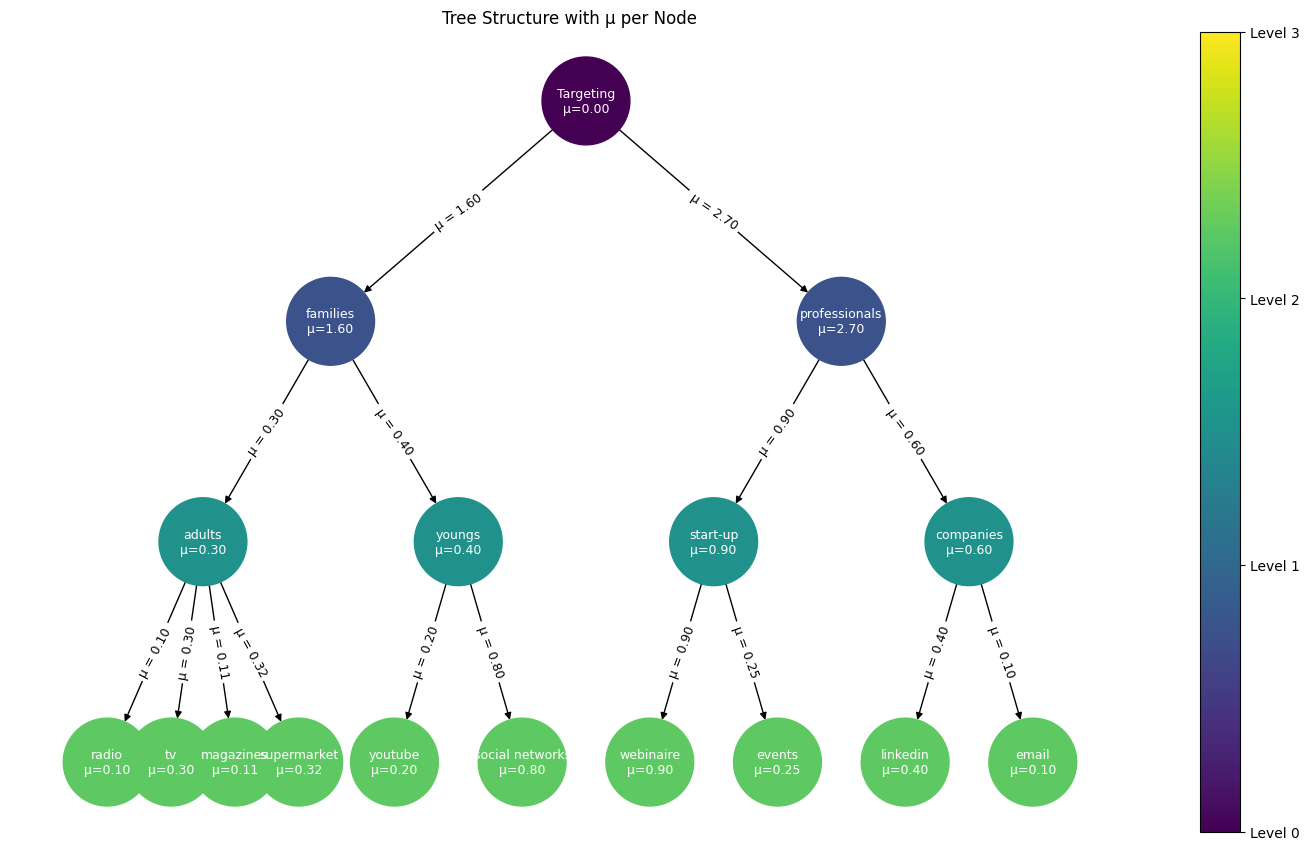

Best arm is webinaire, the optimal path is then ['Targeting', 'professionals', 'start-up', 'webinaire'], and the corresponding reward is 4.5


100%|██████████| 50/50 [02:09<00:00,  2.60s/it]
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_26086/3772789582.py:146: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


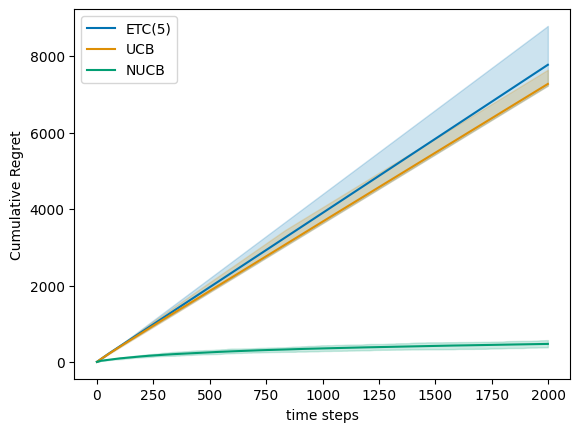

In [45]:
T = 2000  # Finite Horizon
N = 50  # Monte Carlo simulations
q = 10  #choice of percentile display
mus = [0, 
       [1.6, 2.7, 1.5],  # Layer 1
       [[0.3, 0.4], [0.9, 0.6], [0.6, 0.1, 0.4]],  # Layer 2
       [[[0.1, 0.3, 0.11, 0.32], [0.2, 0.8]], [[0.9, 0.25], [0.4, 0.1]], [[0.1, 0.8], [0.3, 0.03], [0.7, 0.01]]] # Layer 3
       ]


# Framework for the experiments
env = StochasticEnvironment(mus, var=1)
env.tree.visualize_tree_mu()
action_set = env.get_action_set()

# Initialization of the agents
ucb = UCB(action_set=action_set)
nucb = NUCB(tree=env.tree)
etc = ExploreThenCommit(action_set=action_set)

# Run experiments
all_data = experiment(env, [etc, ucb, nucb], Nmc=N, T=T)

# Plot results
plot_regret(regrets = all_data, logscale = False, lb = None, q = 0.5)

In [39]:
class StochasticEnvironment(gym.Env):
    def __init__(self, layers, min_children, max_children, p, reward_min, reward_max, var, seed=None):
        self.layers = layers
        self.min_children = min_children
        self.max_children = max_children
        self.p = p
        self.reward_min = reward_min
        self.reward_max = reward_max
        self.var = var
        self.seed = seed
        self.rng = np.random.RandomState(seed)
        self.tree = self.generate_tree()

    def reset(self):
        self.tree.step()

    def generate_tree(self):
        tree = Tree(self.seed)
        node_counter = 0  
        mu_root = self.rng.uniform(self.reward_min, self.reward_max)  # Root mean reward
        root_name = f"Node {node_counter}"
        root = tree.insert(parent_node=None, name=root_name, mean=mu_root, var=self.var)
        node_counter += 1

        def add_layer(parent_node, layer_idx):
            nonlocal node_counter
            if layer_idx >= self.layers:
                return

            num_children = self.rng.randint(self.min_children, self.max_children + 1)
            for i in range(num_children):
                if self.rng.rand() < self.p:  # Optimal reward
                    mean_reward = max(0, self.rng.uniform(self.reward_max - 0.5, self.reward_max + 0.5))
                else:  # Suboptimal reward
                    mean_reward = max(0, self.rng.uniform(self.reward_min - 0.1, self.reward_min + 0.1))

                node_name = f"Node {node_counter}"
                node_counter += 1

                # Adaptation ici : retour de insert peut être node ou (node, parent)
                inserted = tree.insert(parent_node, node_name, mean=mean_reward, var=self.var)
                if isinstance(inserted, tuple):
                    child_node = inserted[0]
                else:
                    child_node = inserted

                add_layer(child_node, layer_idx + 1)

        add_layer(root, 1)
        tree.step()
        return tree

    def get_action_set(self):
        return self.tree.get_all_leaves()
    
    def sample_randomly(self):
        action_set = self.get_action_set()
        random_index = np.random.choice(len(action_set))
        leaf_chosen = action_set[random_index]
        return leaf_chosen

    def get_reward(self, index):
        reward_leaves = self.tree.get_reward_leaves()
        _, _, reward = reward_leaves[index]
        return reward
    
    def get_reward_by_path(self, path):
        return np.sum([node.value for node in path]), [node.value for node in path], np.sum([node.mean for node in path])
    
    def get_total_reward_per_leaf(self):
        action_set = self.get_action_set()
        total_reward_per_leaf = [self.get_reward(leaf) for leaf in action_set]
        self.total_reward_per_leaf = total_reward_per_leaf
        return total_reward_per_leaf
    
    def get_best_strategy_reward(self):
        best_arm_path =  self.tree.find_best_arm_path()
        return [node.name for node in best_arm_path] , np.sum([node.mean for node in best_arm_path])
    
    def step(self):
        self.tree.step()
    
    def render(self, mode='human', close=False):
        pass

In [40]:
colors = sns.color_palette('colorblind')

def experiment(environment, agents, Nmc, T):
    """
    Run multiple simulations of each agent interacting with the environment and record regret.

    This function evaluates a list of agents by having them interact with a given environment
    over multiple Monte Carlo simulations, each lasting for a fixed time horizon.
    For each agent, it computes and stores the regret over time for each trajectory.

    Parameters
    ----------
    environment : object
        The environment in which the agents operate. 
    
    agents : list
        A list of agent instances. Each agent must implement `reset()`, `get_action()`,
        `receive_reward(action, reward)`, and `name()` methods.
    
    Nmc : int
        Number of Monte Carlo simulations to run for each agent.
    
    T : int
        Time horizon (number of rounds) for each simulation.

    Returns
    -------
    all_data : dict
        A dictionary mapping each agent's name (str) to a NumPy array of shape (Nmc, T),
        containing the regret at each time step for each Monte Carlo run.
    """
    all_data = {}
    best_path, best_reward = environment.get_best_strategy_reward()
    print(f"Best arm is {best_path[-1]}, the optimal path is then {best_path}, and the corresponding reward is {best_reward}")
    for agent in agents:
        # Run Nmc simulations for the current agent and compute regrets
        agent_id, regrets = play(environment, agent, Nmc, T)

        # Store the results in the dictionary under the agent's name
        all_data[agent_id] = regrets

    return all_data

def play(environment, agent, Nmc, T):
    """
    Simulate multiple trajectories of agent-environment interaction and record regret.

    This function simulates the interaction between a single agent and an environment 
    over Nmc independent trajectories, each lasting T rounds. It records the pseudo-regret 
    at each time step by comparing the received reward to the best possible reward.

    Parameters
    ----------
    environment : object
        The environment in which the agent operates. 

    agent : object
        The agent being evaluated. 

    Nmc : int
        Number of Monte Carlo trajectories to simulate.

    T : int
        Time horizon (number of steps per trajectory).

    Returns
    -------
    agent_id : str
        The name or identifier of the agent (via `agent.name()`).

    data : np.ndarray
        A NumPy array of shape (Nmc, T), where each entry contains the pseudo-regret 
        (best possible reward minus received reward) at time t in trajectory n.

    Notes
    -----
    The pseudo-regret at each time step is computed using the current mean rewards
    of the environment arms, which assumes those are fixed and known for evaluation.
    """
    # Initialize the regret matrix
    data = np.zeros((Nmc, T))
    best_path, best_reward = environment.get_best_strategy_reward()
    env = environment
    #print(f"Best arm is {best_path[-1]}, the optimal path is then {best_path}, and the corresponding reward is {best_reward}")
    for episode in tqdm(range(Nmc)):
        env.reset()
        #tree.visualize_tree(t=episode)
        agent.reset()   
        
        for t in range(T):
            if agent.nested():
                path = agent.get_path()  # path of nodes
                # Get reward for the chosen path and send it back to the agent
                received_reward, path_reward, mean = env.get_reward_by_path(path)
                agent.receive_reward(received_reward, path_reward, path)

            else:
                leaf, index = agent.get_action()
                mean = leaf.mean
                # Get reward for the chosen action and send it back to the agent
                received_reward = env.get_reward(index)
                agent.receive_reward(received_reward, index)

            env.step()
            # Compute pseudo-regret: time * best mean - received reward
            data[episode, t] = best_reward - mean
        #print(f"Total reward of {agent.name} at episode {episode} is {agent.total_reward}")
        #print(f"Cumulative Pseudo-Regret of {agent.name()} at episode {episode} is {T * best_reward - agent.total_reward}")
    return agent.name(), data


def plot_regret(regrets, logscale = False, lb = None, q = 10, save_pdf = None):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    #compute useful stats
#     regret_stats = {}
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color = colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color = colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    if save_pdf != None:
        plt.savefig(f'{save_pdf}')
    reg_plot.show()

/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_26086/3650587777.py:187: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=range(self.max_level + 1))
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_26086/3650587777.py:191: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


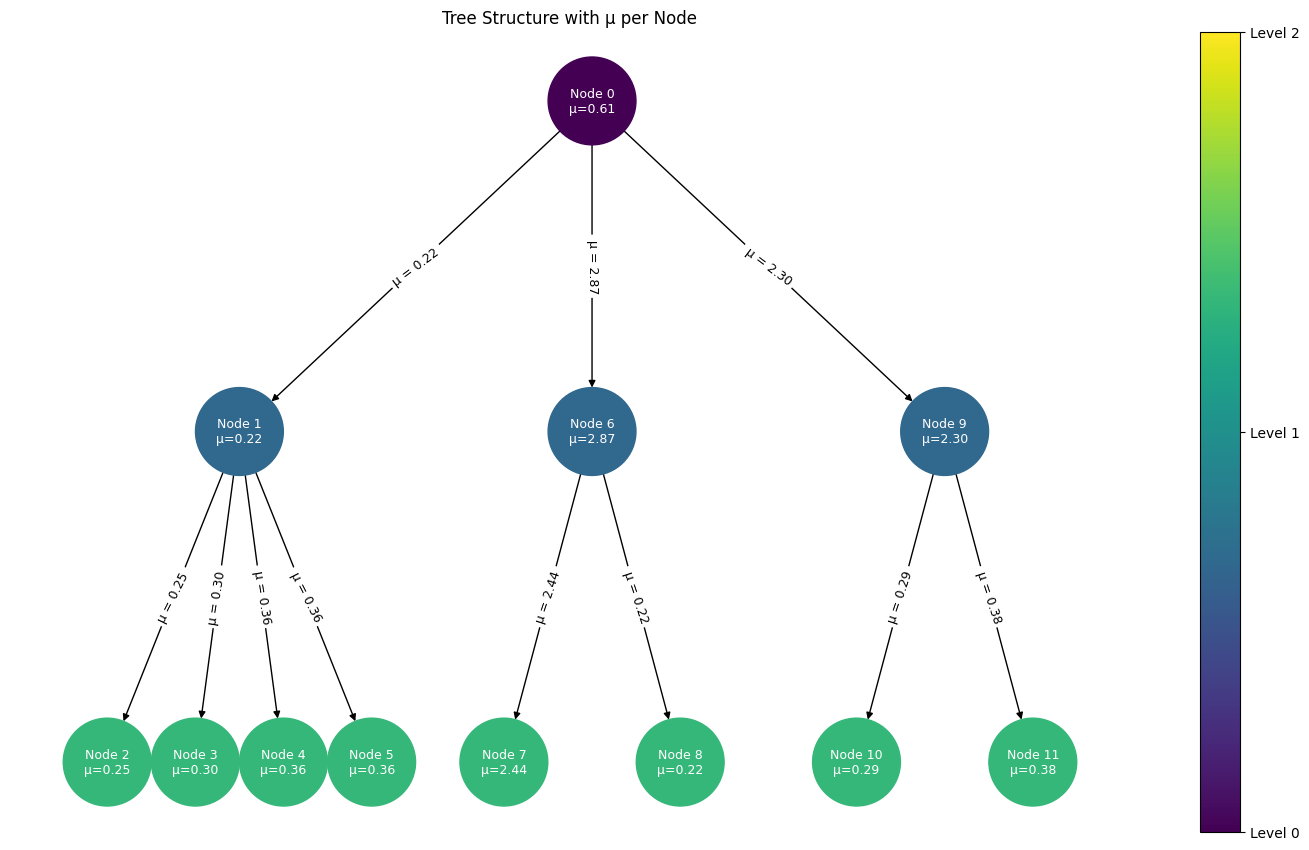

Best arm is Node 7, the optimal path is then ['Node 0', 'Node 6', 'Node 7'], and the corresponding reward is 5.91902270185607


100%|██████████| 50/50 [00:04<00:00, 12.30it/s]
/var/folders/9x/48xzc29960x71dmw5lhg1xz80000gn/T/ipykernel_26086/3772789582.py:146: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  reg_plot.show()


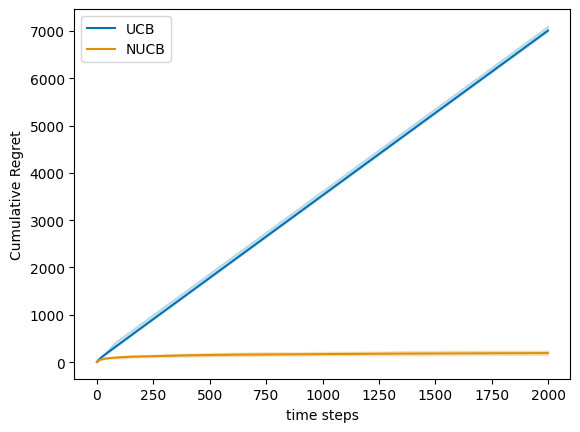

In [ ]:
T = 2000  # Finite Horizon
N = 50  # Monte Carlo simulations
q = 10  #choice of percentile display
mus = [0, 
       [1.6, 2.7, 1.5],  # Layer 1
       [[0.3, 0.4], [0.9, 0.6], [0.6, 0.1, 0.4]],  # Layer 2
       [[[0.1, 0.3, 0.11, 0.32], [0.2, 0.8]], [[0.9, 0.25], [0.4, 0.1]], [[0.1, 0.8], [0.3, 0.03], [0.7, 0.01]]] # Layer 3
       ]


# Framework for the experiments
env = StochasticEnvironment(layers=3, min_children=1, max_children=4, p=0.1, reward_min=0.3, reward_max=2.6, var=1, seed=2025)
env.tree.visualize_tree_mu()
action_set = env.get_action_set()

# Initialization of the agents
ucb = UCB(action_set=action_set)
nucb = NUCB(tree=env.tree)
#etc = ExploreThenCommit(action_set=action_set)

# Run experiments
for layer in [3, 4, 5, 6]:
    print("Layer:", layer)
    env = StochasticEnvironment(layers=layer, min_children=1, max_children=4, p=0.1, reward_min=0.3, reward_max=2.6, var=1, seed=2025)
    all_data = experiment(env, [ucb, nucb], Nmc=N, T=T)

    # Plot results
    plot_regret(regrets = all_data, logscale = False, lb = None, q = 0.5)

In [94]:
env.step()

In [95]:
env.tree.get_all_leaves()